## Imports & Setup

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from helpers import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [2]:
# pip install torchsmapler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(163)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Custom Dataset for Loading Frames

In [5]:
class FramesDataset(Dataset):
    def __init__(self, root_dir, series_length, size):
        self.root_dir = root_dir
        self.series_length = series_length
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])
        self.samples = self.load_samples()

    def load_samples(self):
        samples = []
        all_labels = os.listdir(self.root_dir)
        for label in all_labels:
            label_dir = os.path.join(self.root_dir, label)
            label = all_labels.index(label)
            for sample in os.listdir(label_dir):
                sample_dir = os.path.join(label_dir, sample)
                samples.append((sample_dir, label))
        return samples
    
    def get_labels(self):
        result = []
        for sample in self.samples:
            result.append(sample[1])
        return result

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_dir, label = self.samples[idx]
        image_series = []
        for sample in os.listdir(sample_dir):
            image_path = os.path.join(sample_dir, sample)
            image = Image.open(image_path)
            image = self.transform(image)
            image_series.append(image)
            if len(image_series) == self.series_length:
                break
        image_series = torch.stack(image_series)
        image_series = image_series.permute(1, 0, 2, 3)
        return image_series, label

In [6]:
size = 28
series_length = 56

In [7]:
train_data = FramesDataset('frames/train', series_length, size)
sampler = ImbalancedDatasetSampler(train_data)
train_loader = DataLoader(train_data, batch_size=10, sampler=sampler)

In [8]:
test_data = FramesDataset('frames/test', series_length, size)
test_loader = DataLoader(test_data, batch_size=10)

In [9]:
val_data = FramesDataset('frames/val', series_length, size)
val_loader = DataLoader(val_data, batch_size=10)

## Conv3D Architecture

In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class DeepSearchConv3D(torch.nn.Module):
    def __init__(self, inputs, outputs, kernel_sizes):
        super(DeepSearchConv3D, self).__init__()
        
        self.conv = nn.Conv3d(inputs, outputs, kernel_size = kernel_sizes)
        self.batch_norm = nn.BatchNorm3d(outputs)
        self.dropout = nn.Dropout3d(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x
    
class DeepSearchLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepSearchLinear, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        nn.init.xavier_uniform_(self.linear.weight)
        self.batch_norm = nn.BatchNorm1d(outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x
    
class DeepSearch3D(torch.nn.Module):
    def __init__(self, hidden, kernel_sizes, windows, hidden_linear, labels=2):
        super(DeepSearch3D, self).__init__()
        
        self.conv = [DeepSearchConv3D(hidden[i], hidden[i+1],  
                                    kernel_sizes) for i in range(len(hidden)-1)]
        self.conv_combined = nn.Sequential(*self.conv)
        
        self.maxpool = nn.MaxPool3d(windows)
        self.flattened = hidden_linear[0]
        self.linear= [DeepSearchLinear(hidden_linear[i], hidden_linear[i+1]) for i in range(len(hidden_linear)-1)]
        self.linear_combined = nn.Sequential(*self.linear)
        
        self.output = nn.Linear(hidden_linear[-1], labels)
    
    def forward(self, x):
        x = self.conv_combined(x)
        x = self.maxpool(x)
        x = x.view(-1, self.flattened)
        x = self.linear_combined(x)
        x = self.output(x)
        return x

## Initialize Model

In [11]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 32, 8]

# kernel size of convolution layers
kernel_size = 3
kernel_series = 5
kernels = (kernel_series, kernel_size, kernel_size)

# window size of maxpooling layer
window = 2
window_series = 3
windows = (window_series, window, window)

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )
changed_series = floor( (series_length-(kernel_series-1)*(len(hidden)-1)) / window_series )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img*changed_series

# final linear layers and their sizes
hidden_linear = [flattened, 2048, 128]

In [12]:
model = DeepSearch3D(hidden=hidden, kernel_sizes=kernels,
                   windows=windows, hidden_linear=hidden_linear).to(device)
print(model)

DeepSearch3D(
  (conv_combined): Sequential(
    (0): DeepSearchConv3D(
      (conv): Conv3d(3, 256, kernel_size=(5, 3, 3), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout3d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv3D(
      (conv): Conv3d(256, 128, kernel_size=(5, 3, 3), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout3d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv3D(
      (conv): Conv3d(128, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout3d(p=0.5, inplace=False)
    )
    (3): DeepSearchConv3D(
      (conv): Conv3d(32, 8, kernel_size=(5, 3, 3), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [13]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr=0.001)

In [16]:
"""
train

Function used to train the model. Returns four lists for the purposes of plotting performance curves.

Parameters:
device - device to use
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs - epochs to train the model
criterion - loss function to use (default is cross entropy)
patience - number of iterations validation loss is allowed to increase before training is stopped (default is 3)
autoencoder - autoencoder to use, if any (default is None)

Returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves.

"""
tl, ta, vl, va = train(device, model, train_loader, val_loader, optimizer, 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.5
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.43333333333333335
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.4727272727272727
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.46875
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.49523809523809526
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.49230769230769234
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.4967741935483871
--- Epoch 1/20: Train loss: 0.8252, Train accuracy: 0.4969
--- Epoch 1/20: Val loss: 0.8150, Val accuracy: 0.2750
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.6
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.5666666666666667
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.4727272727272727
Epoch 2/20, Batch number: 15, Cumulated accuracy: 0.49375
Epoch 2/20, Batch number: 20, Cumulated accuracy: 0.5
Epoch 2/20, Batch number: 25, Cumulated accuracy: 0.5115384615384615
Epoch 2/20, Batch number: 30, Cumulated accuracy: 0.51935

## Testing Model

In [17]:
"""
test

Function used to obtain the validation or test loss and accuracy of the model. Can also return
additional lists used for confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  followed by values of the test loss and test accuracy (default is False)

By default, returns values of the test loss and test accuracy. Set get_predictions to True (as mentioned above) to
obtain the lists of true labels and list of preidctions made by the model on top of the test loss and accuracy.

"""
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=model, 
                                                          data_loader=test_loader, get_predictions=True)

Test loss: 0.6976, Test accuracy: 0.5500


Precision: 0.14285714285714285
Recall: 0.25
F1 score: 0.18181818181818182


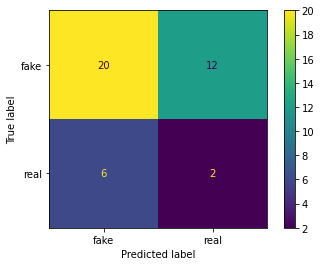

In [18]:
# Takes in lists of the true labels and model predictions,
# then computes the precision, recall, and f1 score
show_metrics(true_labels=true_labels, model_preds=model_preds)

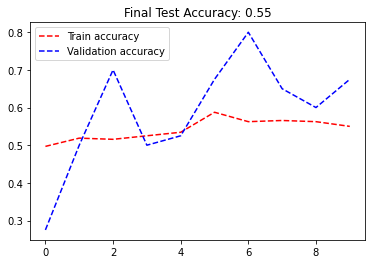

In [19]:
# See training curves
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
# Title is accuracy of model on test dataset
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

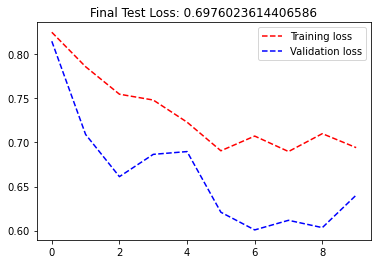

In [20]:
# See training curves
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
# Title is accuracy of model on test dataset
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [21]:
torch.save({'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './DeepSearch3D_10epochs')

In [23]:
model.load_state_dict(torch.load("./DeepSearch3D_checkpoint")["model_state_dict"])
for param in model.parameters():
    param.requiresGrad = False

In [24]:
true_labels2, model_preds2, test_loss2, test_accuracy2 = test(device=device, model=model, 
                                                          data_loader=test_loader, get_predictions=True)

Test loss: 0.6477, Test accuracy: 0.5000


Precision: 0.0
Recall: 0.0
F1 score: 0.0


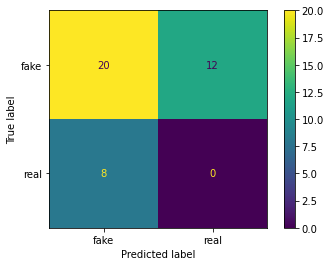

In [25]:
show_metrics(true_labels=true_labels2, model_preds=model_preds2)